First, we have to download the dataset from kaggle for this project. We can import datasets from kaggle by following the steps from this article(https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download dog-breed-identification

 99% 681M/691M [00:21<00:00, 28.1MB/s]
100% 691M/691M [00:21<00:00, 33.3MB/s]


In [ ]:
! unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
!pip install livelossplot

     |████████████████████████████████| 793 kB 5.6 MB/s 
     |████████████████████████████████| 381 kB 40.5 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

import cv2
import PIL
import os
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)

import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,BatchNormalization,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2,preprocess_input
import gc
import skimage.io
from livelossplot import PlotLossesKeras

In [3]:
# Make the train and test datasets directory.
train_dir = './train/'
test_dir = './test/'
train_labels = pd.read_csv('./labels.csv')
submission=pd.read_csv('./sample_submission.csv')

In [4]:
train_size = len(os.listdir(train_dir))
test_size = len(os.listdir(test_dir))

print(train_size,test_size)
print(train_labels.shape)
print(submission.shape)

10222 10357
(10222, 2)
(10357, 121)


In [5]:
target, dog_breeds = pd.factorize(train_labels['breed'], sort = True)
train_labels['target'] = target

In [6]:
display(train_labels.head())
display(submission.head())

,id,breed,target
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [7]:
train_labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

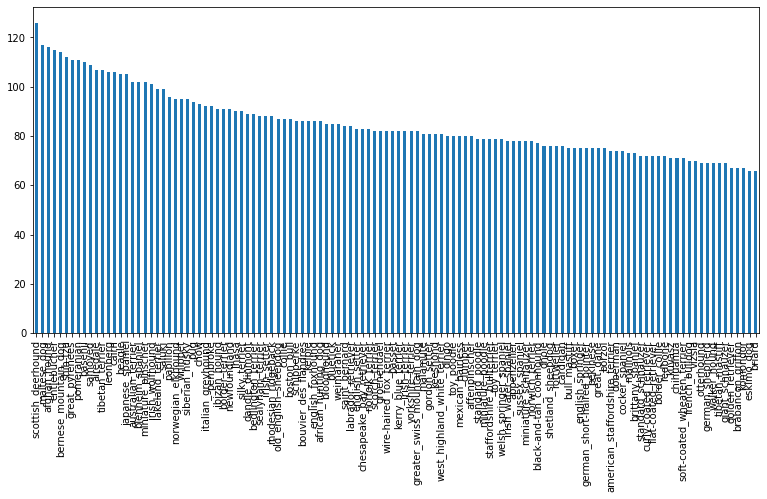

In [8]:
plt.figure(figsize=(13, 6))
train_labels['breed'].value_counts().plot(kind='bar')
plt.show()

## Preparing the datasets

In [9]:
labels=[]
data=[]
for i in range(train_labels.shape[0]):
    data.append(train_dir + train_labels['id'].iloc[i]+'.jpg')
    labels.append(train_labels['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels
print(df.shape)
display(df.head())

del labels
del data

(10222, 2)


,images,target
0,./train/000bec180eb18c7604dcecc8fe0dba07.jpg,19
1,./train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,37
2,./train/001cdf01b096e06d78e9e5112d419397.jpg,85
3,./train/00214f311d5d2247d5dfe4fe24b2303d.jpg,15
4,./train/0021f9ceb3235effd7fcde7f7538ed62.jpg,49


In [10]:
test_data=[]
for i in range(submission.shape[0]):
    test_data.append(test_dir + submission['id'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']
print(df_test.shape)
display(df_test.head())

del test_data

(10357, 1)


,images
0,./test/000621fb3cbb32d8935728e48679680e.jpg
1,./test/00102ee9d8eb90812350685311fe5890.jpg
2,./test/0012a730dfa437f5f3613fb75efcd4ce.jpg
3,./test/001510bc8570bbeee98c8d80c8a95ec1.jpg
4,./test/001a5f3114548acdefa3d4da05474c2e.jpg


In [11]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], stratify = df['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

print(train.shape)
display(train.head())
print(validation.shape)
display(validation.head())

del X_train, X_val, y_train, y_val

(8177, 2)


,images,target
9988,./train/fa85c1ccb2fa7ff39d78bf2b821bcdd5.jpg,117
3484,./train/56cd0b7b466c0adb4a1c4638d70fe09c.jpg,111
1532,./train/25d44cc514ac6625b1ea11ab91b4ba2f.jpg,70
937,./train/16ed388064b485a047d02a147e0a5cff.jpg,70
6453,./train/a290e911f2c3fe117944ef7e0b42cb03.jpg,45


(2045, 2)


,images,target
3657,./train/5b1ab930d787b6d7addebf6858b0ba4f.jpg,117
292,./train/070e8ff540cc8113939ae5dba4a24f80.jpg,28
7654,./train/bfbc332f78159db3fa558392311ffed8.jpg,91
1669,./train/29743dcc4d439615133f2024b50aab15.jpg,70
5694,./train/8f9f48b4ad92e8f3082d2ab40d9f5e51.jpg,50


In [12]:
# Global variables
N_EPOCHS = 10
BATCH_SIZE = 32
IMG_HEIGHT = 299
IMG_WIDTH = 299

In [13]:
# Image data agumentation
train_datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True, zoom_range=0.2)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode='raw')

Found 8177 validated image filenames.
Found 2045 validated image filenames.


## Build the model

In [14]:
#building the model using Xception with input shape of our image array
#weights for our network will be from of imagenet dataset
#we will not include the first Dense layer
base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(299,299,3)) 
# train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
base_model.trainable = False

inputs = Input(shape=(299, 299, 3))
x = xception.preprocess_input(inputs) ##  tf.keras.applications.xception.preprocess_input

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here by passing `training=False`.
x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)

#     adding extra dense layer
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(.7)(x)
#     x = Dense(512, activation='relu')(x)

x = Dropout(.5)(x)
outputs = Dense(120, activation='softmax')(x)
model = Model(inputs, outputs)

display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

None

In [15]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [16]:
n_train_steps = train.shape[0]//BATCH_SIZE
n_val_steps=validation.shape[0]//BATCH_SIZE
print("Number of training and validation steps: {} and {}".format(n_train_steps, n_val_steps))

Number of training and validation steps: 255 and 63


In [17]:
EarlyStop_callback = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

In [18]:
model.fit(
    train_generator,
    epochs=N_EPOCHS,
    validation_data=validation_generator,
    callbacks=[EarlyStop_callback])

Epoch 1/10
256/256 [==============================] - 275s 1s/step - loss: 1.6069 - accuracy: 0.6990 - val_loss: 0.4757 - val_accuracy: 0.8958
Epoch 2/10
256/256 [==============================] - 264s 1s/step - loss: 0.5105 - accuracy: 0.8599 - val_loss: 0.3593 - val_accuracy: 0.9012
Epoch 3/10
256/256 [==============================] - 267s 1s/step - loss: 0.4110 - accuracy: 0.8817 - val_loss: 0.3219 - val_accuracy: 0.8993
Epoch 4/10
256/256 [==============================] - 268s 1s/step - loss: 0.3614 - accuracy: 0.8897 - val_loss: 0.3134 - val_accuracy: 0.9017
Epoch 5/10
256/256 [==============================] - 265s 1s/step - loss: 0.3454 - accuracy: 0.8947 - val_loss: 0.3148 - val_accuracy: 0.9037
Epoch 6/10
256/256 [==============================] - 265s 1s/step - loss: 0.3169 - accuracy: 0.9030 - val_loss: 0.3110 - val_accuracy: 0.9002
Epoch 7/10
256/256 [==============================] - 264s 1s/step - loss: 0.3041 - accuracy: 0.9039 - val_loss: 0.3119 - val_accuracy: 0.8934

In [19]:
#Save the model for prediction
model.save("model")

#load the model
model = load_model("model")

INFO:tensorflow:Assets written to: model/assets


## Make prediction on test dataset

In [21]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='images',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode=None
)

Found 10357 validated image filenames.


In [22]:
predictions = model.predict(
    test_generator,
    verbose=1         
)

324/324 [==============================] - 166s 509ms/step


## Save the predictions to original sibmission csv

In [23]:
submission.loc[:, dog_breeds] = predictions
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.782991e-06,1.079207e-06,9.925598e-07,1.644900e-07,7.511962e-08,1.955779e-07,1.236856e-07,2.611397e-07,2.492326e-07,...,6.278171e-07,3.382863e-06,2.012693e-06,2.516050e-07,6.853330e-07,2.695842e-08,1.048854e-07,1.576108e-07,7.910117e-07,4.593653e-08
1,00102ee9d8eb90812350685311fe5890,1.153679e-06,1.730908e-07,1.407473e-07,7.329311e-07,6.954371e-07,6.068468e-06,3.095947e-07,1.191245e-06,1.015660e-07,...,1.203445e-06,4.151338e-07,1.320642e-06,5.647698e-07,5.169440e-07,1.236458e-07,1.628704e-05,3.680724e-07,4.738572e-07,2.560865e-07
2,0012a730dfa437f5f3613fb75efcd4ce,1.165104e-08,8.186020e-05,7.995619e-07,2.763473e-07,2.849125e-08,3.093751e-07,3.007106e-09,6.362862e-09,3.932059e-06,...,3.402068e-09,2.942432e-08,1.449680e-07,1.025933e-05,4.034791e-06,1.460165e-04,1.911372e-08,8.314636e-07,1.446324e-07,1.684175e-08
3,001510bc8570bbeee98c8d80c8a95ec1,1.878403e-04,3.569612e-07,6.022655e-07,3.764843e-07,1.639204e-04,5.444942e-06,1.660078e-06,1.811934e-06,2.712632e-06,...,5.065303e-06,1.112250e-05,5.869716e-06,2.473161e-06,1.553369e-06,4.925524e-07,4.855225e-06,1.385758e-05,4.255106e-07,3.099978e-07
4,001a5f3114548acdefa3d4da05474c2e,3.263805e-03,5.775785e-05,4.151520e-06,2.418778e-07,1.549054e-06,1.215119e-05,4.905023e-06,7.525085e-06,6.811872e-06,...,3.761027e-06,6.578755e-06,2.423928e-06,3.299968e-06,2.208402e-06,2.255187e-07,9.354480e-06,3.389640e-05,1.437903e-05,4.053837e-05
